## Loading Dataset

### Kaggle API Configuration

In [28]:
# Install the Kaggle API client
!pip install -q Kaggle opencv-python tensorflow umap-learn tqdm


# Upload your kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pavankathikr","key":"c05839e5d7e279fd07ecabf2511872df"}'}

In [29]:
# Create a .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle
# Copy the uploaded kaggle.json to the .kaggle directory
!cp kaggle.json ~/.kaggle/
# Set appropriate permissions (read/write for owner only)
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API key uploaded and configured!")

Kaggle API key uploaded and configured!


### Download Zip File & Extract Dataset

In [30]:
# Download the dataset
!kaggle datasets download -d joebeachcapital/defungi


Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/defungi
License(s): Attribution 4.0 International (CC BY 4.0)
 53% 79.0M/149M [00:00<00:00, 823MB/s]
100% 149M/149M [00:00<00:00, 328MB/s] 


In [31]:
import zipfile
import os
# unzip zip file
zip_file_name = 'defungi.zip'
if os.path.exists(zip_file_name):
  with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('defungi_data')
else:
  print(f'Error: {zip_file_name} not found')

## Dataset Structure & Overview

### Folder Structure

In [32]:
!ls defungi_data
# !ls defungi_data/H1/

H1  H2	H3  H5	H6


**<center></center>**
<p align='center'>
There are the five classes of fungi (<b>H1, H2, H3, H5, H6</b>).
</br>Separate folders (<b>H1, H2, H3, H5, H6</b>) are present corresponding to each class.</br>No separate train, validation, and test sets are provided.
</p>

### Extract Image Attributes

In [33]:
# For each image, store its filepath, class_label, width, height, and aspect_ratio
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import os

images_root_folder = 'defungi_data'
image_attributes = []
consolidated_histogram = np.zeros(256, dtype=int)
class_wise_histogram = {
    'H1': np.zeros(256, dtype=int),
    'H2': np.zeros(256, dtype=int),
    'H3': np.zeros(256, dtype=int),
    'H5': np.zeros(256, dtype=int),
    'H6': np.zeros(256, dtype=int)
}

for sub_folder in os.listdir(images_root_folder):
  sub_folder_path = os.path.join(images_root_folder, sub_folder)
  if os.path.isdir(sub_folder_path):
    for image_file_name in os.listdir(sub_folder_path):
      image_file_path = os.path.join(sub_folder_path, image_file_name)

      dict_image_properties = {
          'path': image_file_path,
          'class_label': sub_folder,
          'is_corrupted' : False
      }
      try:
        with Image.open(image_file_path) as image:
          # Check file integrity
          image.verify()
          # Reopen Image after verification (known issue with Pillow)
          image = Image.open(image_file_path)

          # Load image to see if there are any further issues
          image.load()
          width, height = image.size

          dict_image_properties['width'] = width
          dict_image_properties['height'] = height
          dict_image_properties['aspect_ratio'] = width / height
          dict_image_properties['mode'] = image.mode
          dict_image_properties['file_format'] = image.format

          # Convert image to gray scale
          gray_image = image.convert('L')
          gray_scale_pixels_array = np.array(gray_image)
          current_hist_counts, _ = np.histogram(gray_scale_pixels_array.flatten(),
                                                bins=256, range=(0, 256))
          consolidated_histogram += current_hist_counts
          class_wise_histogram[sub_folder] += current_hist_counts

          # Any custom criteria for corrupted images
          # if gray_scale_pixels_array.mean() < 5 or gray_scale_pixels_array.std() < 10:
          #   dict_image_properties['is_corrupted'] = True

          image_array = np.array(image)
          dict_image_properties['number_of_bits'] = image_array.dtype
          dict_image_properties['normalized_mean_pixel_intensity_R'] = np.mean(image_array[:, :, 0])/255.0
          dict_image_properties['normalized_mean_pixel_intensity_G'] = np.mean(image_array[:, :, 1])/255.0
          dict_image_properties['normalized_mean_pixel_intensity_B'] = np.mean(image_array[:, :, 2])/255.0

      except Exception as ex:
        print(f'exception while processing image-{image_file_path}. Exception-{ex}')
        dict_image_properties['is_corrupted'] = True

      image_attributes.append(dict_image_properties)

dataset_image_properties = pd.DataFrame(image_attributes)

print(dataset_image_properties.head())

                            path class_label  is_corrupted  width  height  \
0   defungi_data/H5/H5_43a_3.jpg          H5         False    500     500   
1  defungi_data/H5/H5_127a_1.jpg          H5         False    500     500   
2  defungi_data/H5/H5_109a_2.jpg          H5         False    500     500   
3   defungi_data/H5/H5_88a_3.jpg          H5         False    500     500   
4  defungi_data/H5/H5_126b_2.jpg          H5         False    500     500   

   aspect_ratio mode file_format number_of_bits  \
0           1.0  RGB        JPEG          uint8   
1           1.0  RGB        JPEG          uint8   
2           1.0  RGB        JPEG          uint8   
3           1.0  RGB        JPEG          uint8   
4           1.0  RGB        JPEG          uint8   

   normalized_mean_pixel_intensity_R  normalized_mean_pixel_intensity_G  \
0                           0.506940                           0.611916   
1                           0.586812                           0.594647   
2    

In [34]:
print(dataset_image_properties.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9114 entries, 0 to 9113
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   path                               9114 non-null   object 
 1   class_label                        9114 non-null   object 
 2   is_corrupted                       9114 non-null   bool   
 3   width                              9114 non-null   int64  
 4   height                             9114 non-null   int64  
 5   aspect_ratio                       9114 non-null   float64
 6   mode                               9114 non-null   object 
 7   file_format                        9114 non-null   object 
 8   number_of_bits                     9114 non-null   object 
 9   normalized_mean_pixel_intensity_R  9114 non-null   float64
 10  normalized_mean_pixel_intensity_G  9114 non-null   float64
 11  normalized_mean_pixel_intensity_B  9114 non-null   float

In [35]:
print(dataset_image_properties.describe())


        width  height  aspect_ratio  normalized_mean_pixel_intensity_R  \
count  9114.0  9114.0        9114.0                        9114.000000   
mean    500.0   500.0           1.0                           0.537009   
std       0.0     0.0           0.0                           0.047986   
min     500.0   500.0           1.0                           0.107073   
25%     500.0   500.0           1.0                           0.512241   
50%     500.0   500.0           1.0                           0.529833   
75%     500.0   500.0           1.0                           0.554286   
max     500.0   500.0           1.0                           0.822067   

       normalized_mean_pixel_intensity_G  normalized_mean_pixel_intensity_B  
count                        9114.000000                        9114.000000  
mean                            0.538451                           0.508599  
std                             0.035592                           0.067696  
min                  

In [36]:
dataset_image_properties['number_of_bits'].value_counts()

number_of_bits
uint8    9114
Name: count, dtype: int64

In [37]:
dataset_image_properties['class_label'].value_counts()

class_label
H1    4404
H2    2334
H3     819
H5     818
H6     739
Name: count, dtype: int64

<ul>
  <li>Total <b>9114</b> Images are present across all five classes.</li>
  <li>All Images are having <b>Same</b> Height, Width, Aspect Ratio.</li>
  <li>All images are <b>8 bit</b> Images.</li>
  <li>Class wise Image counts:
  <ul>
      <li>H1 - 4404</li>
      <li>H2 - 2334</li>
      <li>H3 - 819</li>
      <li>H5 - 818</li>
      <li>H6 - 739</li>
  </ul>
  </li>
</ul>



### Class (Fungus Type) Distribution

Text(0.5, 1.0, 'Image Counts of various Fungus Types')

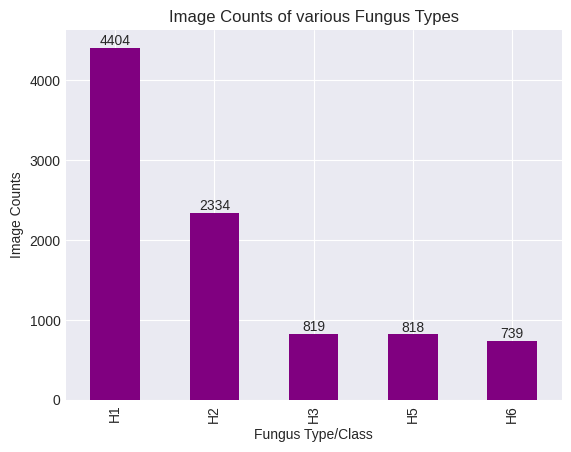

In [38]:
defungi_class_value_counts = dataset_image_properties['class_label'].value_counts()
# print(defungi_class_value_counts)
ax = defungi_class_value_counts.plot(kind='bar', color='purple')
for idx, count in enumerate(defungi_class_value_counts):
  ax.text(idx, count, str(count), ha='center', va='bottom')

plt.xlabel('Fungus Type/Class')
plt.ylabel('Image Counts')
plt.title('Image Counts of various Fungus Types')

<p align='center'>
We can observe <b>imabalnce</b> in dataset in terms of Fungus Type class counts.</br>We can consider strategies like <b>Data Augmentation, oversampling, undersampling, or using weighted loss functions</b> later in model training.
</p>

## Image Characteristics

### Image dimensions

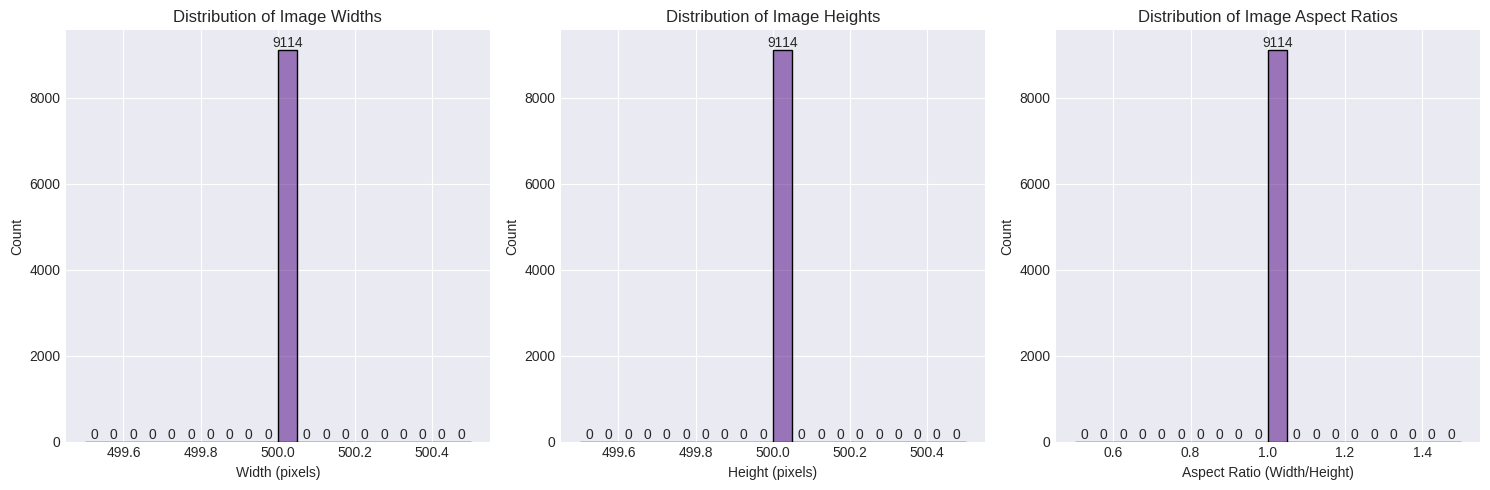

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(dataset_image_properties['width'], bins=20,
                   kde=True, color='indigo', ax=axes[0])
axes[0].set_title('Distribution of Image Widths')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Count')


sns.histplot(dataset_image_properties['height'], bins=20,
                   kde=True, color='indigo', ax=axes[1])
axes[1].set_title('Distribution of Image Heights')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Count')


sns.histplot(dataset_image_properties['aspect_ratio'], bins=20,
                   kde=True, color='indigo', ax=axes[2])
axes[2].set_title('Distribution of Image Aspect Ratios')
axes[2].set_xlabel('Aspect Ratio (Width/Height)')
axes[2].set_ylabel('Count')

for ax in axes:
  for p in ax.patches:
    bar_height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            bar_height, int(bar_height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


**<center>Dimensions (Width, Height, Aspect Ratio, Resolution) of all the images are consistent</center>**

### Image Mode/Color Channels distribution

Text(0.5, 1.0, 'Mode of Images')

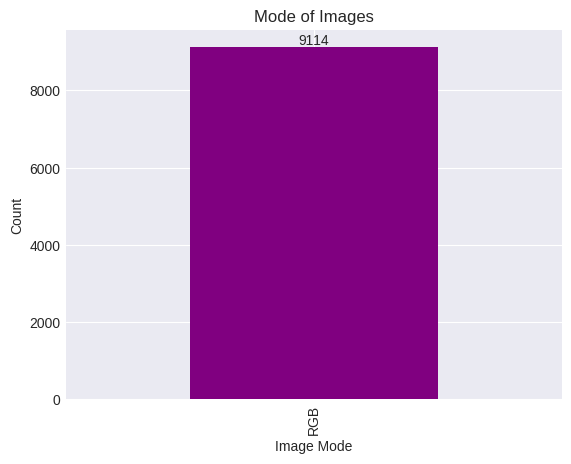

In [40]:
image_mode_value_counts = dataset_image_properties['mode'].value_counts()
ax_mode = image_mode_value_counts.plot(kind='bar', color='purple')
for idx, count in enumerate(image_mode_value_counts):
  ax_mode.text(idx, count, str(count), ha='center', va='bottom')

plt.xlabel('Image Mode')
plt.ylabel('Count')
plt.title('Mode of Images')

<p align='center'>All Images are present in one mode - <b>RGB</b> (3 Channels)
</p>

### Image File Format distribution

Text(0.5, 1.0, 'Image File Format Distribution')

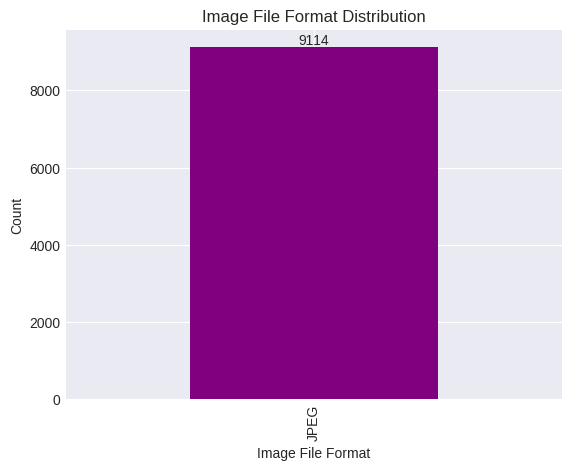

In [41]:
file_format_value_counts = dataset_image_properties['file_format'].value_counts()
ax_format = file_format_value_counts.plot(kind='bar', color='purple')

for idx, count in enumerate(file_format_value_counts):
  ax_format.text(idx, count, str(count), ha='center', va='bottom')

plt.xlabel('Image File Format')
plt.ylabel('Count')
plt.title('Image File Format Distribution')

<p align='center'>All Image files are in <b>JPEG</b> Format</p>

### Mean Channel Intensities (Normalized 0-1)

In [42]:
dataset_image_properties[['normalized_mean_pixel_intensity_R','normalized_mean_pixel_intensity_G','normalized_mean_pixel_intensity_B']].describe()

normalized_mean_pixel_intensity_R  normalized_mean_pixel_intensity_G  \
count                        9114.000000                        9114.000000   
mean                            0.537009                           0.538451   
std                             0.047986                           0.035592   
min                             0.107073                           0.102017   
25%                             0.512241                           0.522312   
50%                             0.529833                           0.535138   
75%                             0.554286                           0.550934   
max                             0.822067                           0.792873   

       normalized_mean_pixel_intensity_B  
count                        9114.000000  
mean                            0.508599  
std                             0.067696  
min                             0.106218  
25%                             0.488582  
50%                             0.515518  
75%                             0.543980  
max                             0.774402

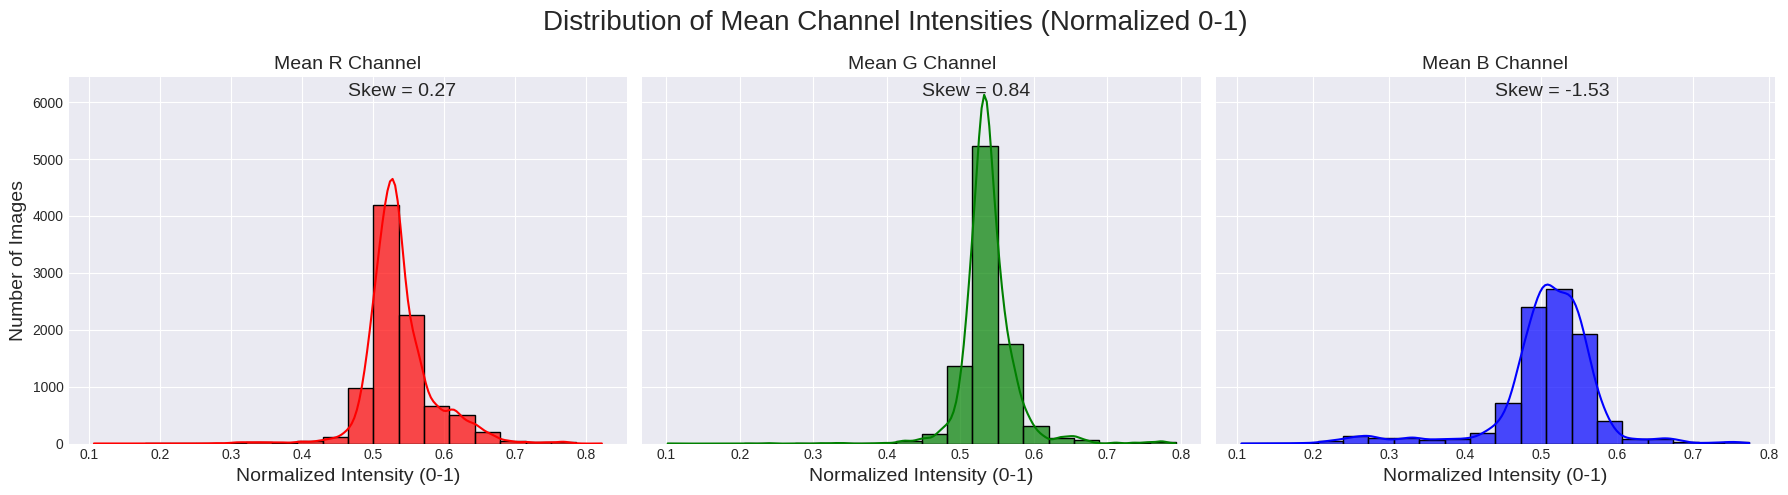

In [43]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
fig.suptitle('Distribution of Mean Channel Intensities (Normalized 0-1)', fontsize=20)
colors = ['red', 'green', 'blue']
channel_names = ['R', 'G', 'B']

for index, channel in enumerate(channel_names):
  column_name = 'normalized_mean_pixel_intensity_' + channel
  sns.histplot(data=dataset_image_properties, x=column_name,
               bins=20, color=colors[index], alpha=0.7, edgecolor='black',
               kde=True, ax=axes[index]) #, hue='class_label'
  axes[index].annotate(text=f'Skew = {np.round(skew(dataset_image_properties[column_name]), decimals=2)}',
                       xy=(0.5, 0.95), xycoords='axes fraction', fontsize=14)
  axes[index].set_title(f'Mean {channel} Channel', fontsize=14)
  axes[index].set_xlabel('Normalized Intensity (0-1)', fontsize=14)
  axes[index].set_ylabel('Number of Images', fontsize=14)
plt.tight_layout()
plt.show()


<p align='center'>
  <b>Balanced Normalized mean intensity</b> is observed for R G B Channels.
  <br/>Observe the <b>negative skew value (-1.53)</b> for Channel B.
</P>

## Image Content & Quality

### Visual Display

/tmp/ipython-input-44-2367977347.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ,group_keys=False).apply(lambda x:


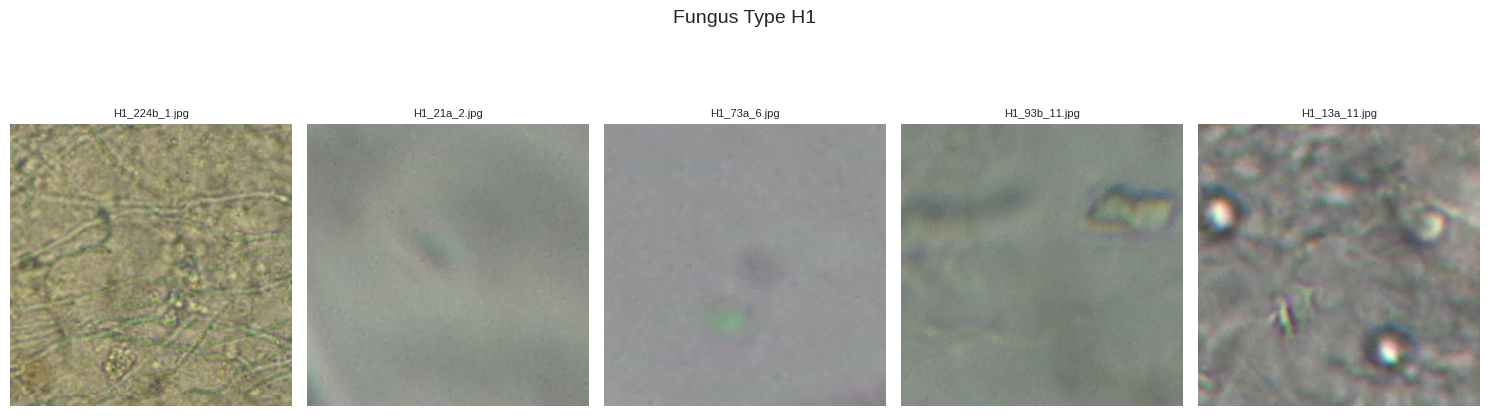

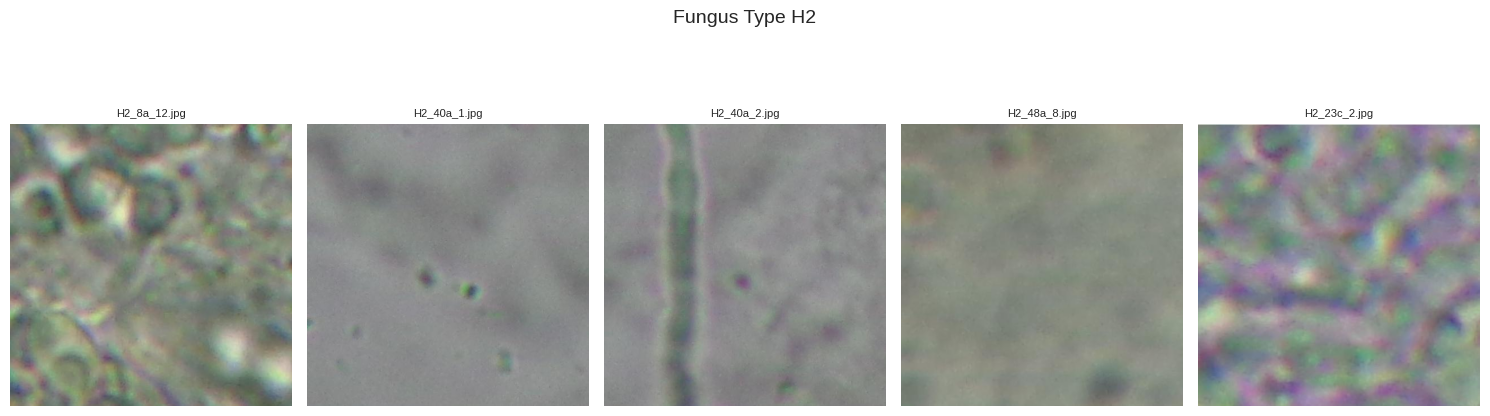

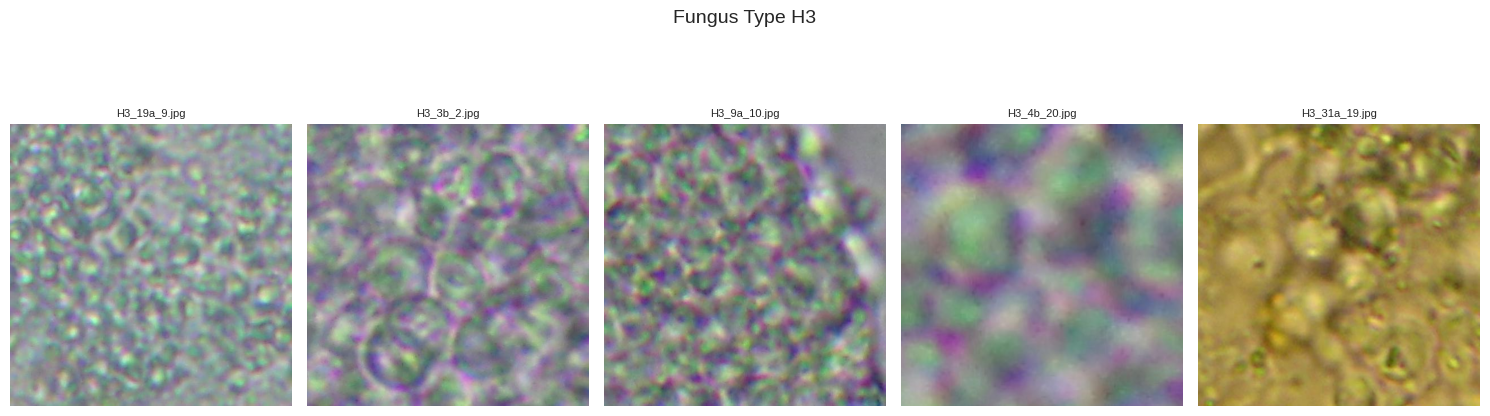

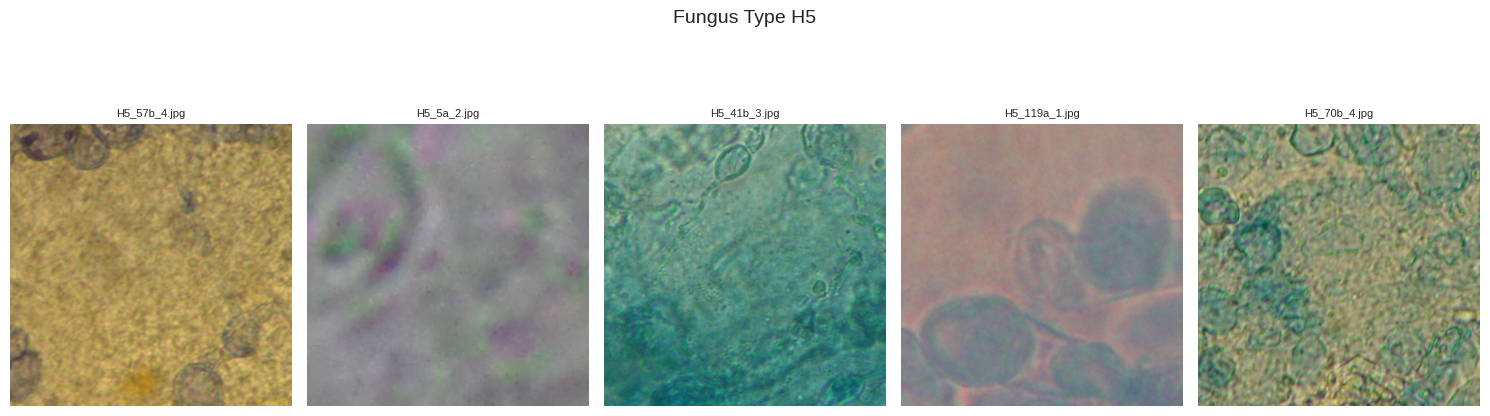

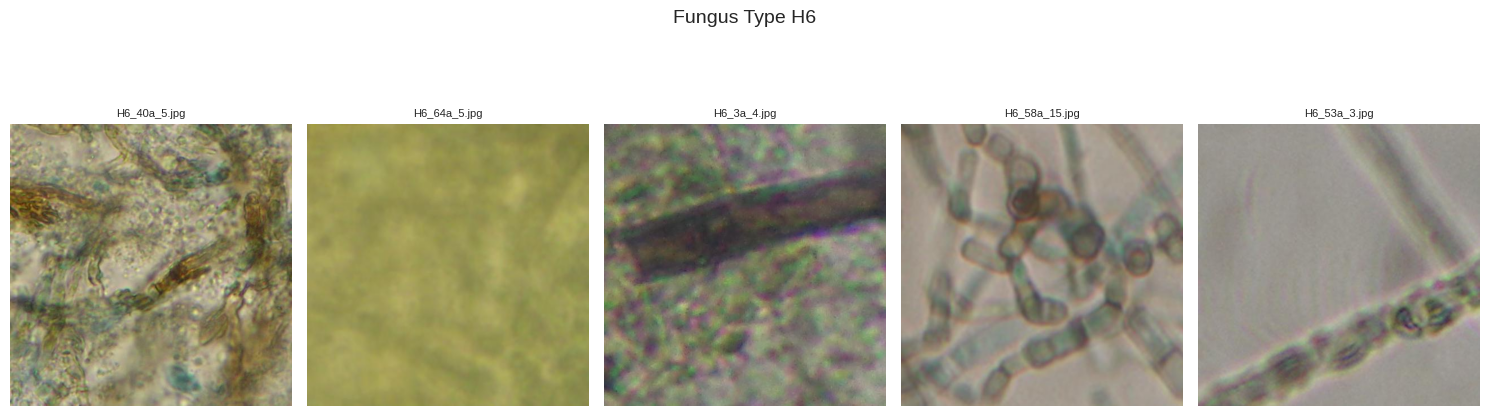

In [44]:
number_of_images_to_show = 5
# Get top 3 random images for display purpose for each fungus type
# result = dataset_image_properties.groupby('class_label', group_keys=True)
# for name, group in result:
#   print(name)
#   print(group)

result = dataset_image_properties.groupby('class_label'
                                          ,group_keys=False).apply(lambda x:
                                                                  x.sample(number_of_images_to_show))

# fig, axes = plt.subplots(1,3)
# filtered_rows = result[result['class_label'] == 'H1']
# list(zip(axes, filtered_rows.iterrows()))
unique_fungus_types = result['class_label'].unique()
for fungus_type in unique_fungus_types:
  filtered_rows = result[result['class_label'] == fungus_type]
  # print(filtered_rows)
  fig, axes = plt.subplots(1, number_of_images_to_show, figsize=(15,5))
  fig.suptitle(f'Fungus Type {fungus_type}', fontsize=14)
  for ax, (_, row) in zip(axes, filtered_rows.iterrows()):
    image = Image.open(row['path'])
    ax.imshow(image)
    ax.set_title(row['path'].split('/')[-1], fontsize=8)
    ax.axis('off')
  plt.tight_layout()
  plt.show()



### Duplicate & Corrupted Images

In [45]:
dataset_image_properties[dataset_image_properties['is_corrupted'] == True]

Empty DataFrame
Columns: [path, class_label, is_corrupted, width, height, aspect_ratio, mode, file_format, number_of_bits, normalized_mean_pixel_intensity_R, normalized_mean_pixel_intensity_G, normalized_mean_pixel_intensity_B]
Index: []

<p align='center'><b>No Corrupted Images are observed</b></p>

In [46]:
import hashlib
from collections import defaultdict

hashes = defaultdict(list)
for sub_folder in os.listdir(images_root_folder):
  sub_folder_path = os.path.join(images_root_folder, sub_folder)
  if os.path.isdir(sub_folder_path):
    for image_file_name in os.listdir(sub_folder_path):
      image_file_path = os.path.join(sub_folder_path, image_file_name)
      try:
        # open file in binary read mode
        with open(image_file_path, 'rb') as img:
          # Perform hashing using MD5
          image_hash = hashlib.md5(img.read()).hexdigest()
          hashes[image_hash].append(image_file_path)

      except Exception as ex:
        print(f"Could not hash file {image_file_path}: {ex}")

duplicate_images_dict = {hash:image_paths for hash,image_paths in hashes.items() if len(image_paths) > 1  }
duplicate_images_dict.values()

dict_values([['defungi_data/H5/H5_118a_4.jpg', 'defungi_data/H5/H5_27a_4.jpg'], ['defungi_data/H5/H5_113a_6.jpg', 'defungi_data/H5/H5_114a_6.jpg'], ['defungi_data/H5/H5_118a_3.jpg', 'defungi_data/H5/H5_27a_3.jpg'], ['defungi_data/H5/H5_114a_1.jpg', 'defungi_data/H5/H5_113a_1.jpg'], ['defungi_data/H5/H5_113a_3.jpg', 'defungi_data/H5/H5_114a_3.jpg'], ['defungi_data/H5/H5_113a_4.jpg', 'defungi_data/H5/H5_114a_4.jpg'], ['defungi_data/H5/H5_118a_2.jpg', 'defungi_data/H5/H5_27a_2.jpg'], ['defungi_data/H5/H5_27a_5.jpg', 'defungi_data/H5/H5_118a_5.jpg'], ['defungi_data/H5/H5_113a_5.jpg', 'defungi_data/H5/H5_114a_5.jpg'], ['defungi_data/H5/H5_118a_1.jpg', 'defungi_data/H5/H5_27a_1.jpg'], ['defungi_data/H5/H5_47a_1.jpg', 'defungi_data/H5/H5_98a_1.jpg'], ['defungi_data/H5/H5_118a_6.jpg', 'defungi_data/H5/H5_27a_6.jpg'], ['defungi_data/H5/H5_114a_2.jpg', 'defungi_data/H5/H5_113a_2.jpg'], ['defungi_data/H6/H6_75a_12.jpg', 'defungi_data/H6/H6_58a_12.jpg'], ['defungi_data/H6/H6_5a_6.jpg', 'defungi_da

<p align='center'>
 <b>Duplicate Images</b> result in <b>Data leakage and Overfitting</b>, leading to model that may fail to generalize well to unseen data. </br>Above are exact duplicates, if model still doesn't generalize well, we probably need to look for advanced duplicate detection techniques like <b>Perceptual Hashing & CNN Embeddings </b>
</p>

### Cluster Visualization & Dissimilarity Within Class

Using TensorFlow/Keras with model: resnet50
Model output shape (embedding dimension): (None, 2048)


Features for H6: 100%|██████████| 24/24 [02:12<00:00,  5.53s/it]


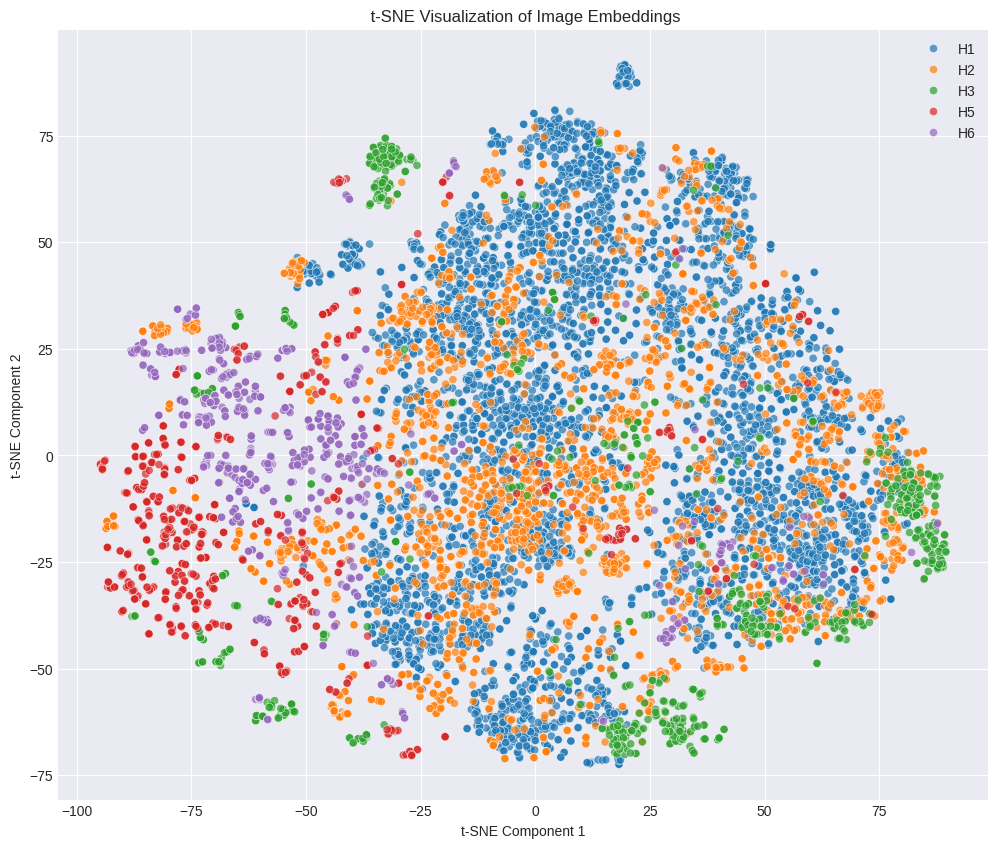

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


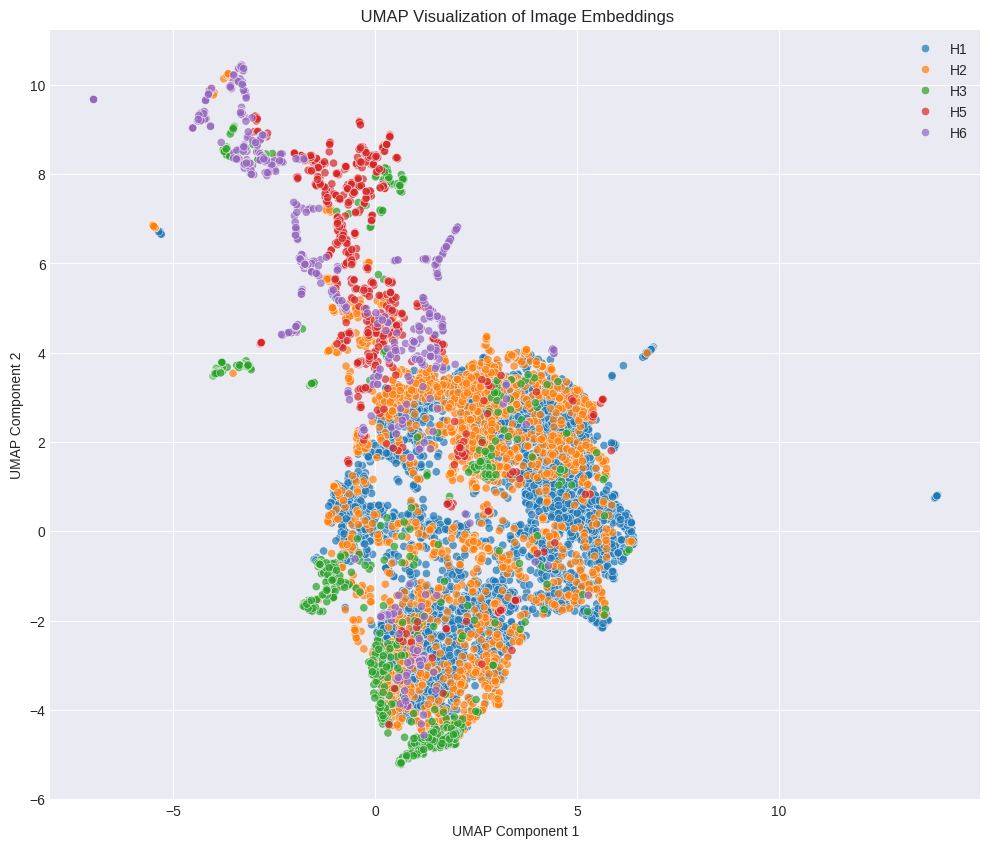

H1 - Avg Cosine Dissimilarity =0.2898
H2 - Avg Cosine Dissimilarity =0.3219
H3 - Avg Cosine Dissimilarity =0.3329
H5 - Avg Cosine Dissimilarity =0.4519
H6 - Avg Cosine Dissimilarity =0.4958


In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.manifold import TSNE
from umap import UMAP
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

BATCH_SIZE=32
TARGET_IMAGE_SIZE = (224, 224)

# Load Pre-Trained Model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model.trainable=False

print(f'Using TensorFlow/Keras with model: {model.name}')
print(f'Model output shape (embedding dimension): {model.output_shape}')

# Extract Features
def extract_features(data_dir):
  features_list = []
  labels_list = []
  image_paths_list = []

  for sub_folder in sorted(os.listdir(images_root_folder)):
    sub_folder_path = os.path.join(images_root_folder, sub_folder)

    if os.path.isdir(sub_folder_path):
      current_class_images = []
      current_class_paths = []

      for image_file_name in os.listdir(sub_folder_path):
        image_file_path = os.path.join(sub_folder_path, image_file_name)
        try:
          # No need of explcit RGB conversion as all images color images
          img = Image.open(image_file_path)
          img = img.resize(TARGET_IMAGE_SIZE)
          img_array = image.img_to_array(img)
          img_array = np.expand_dims(img_array, axis=0)
          img_array = preprocess_input(img_array)
          current_class_images.append(img_array)
          current_class_paths.append(image_file_path)

        except Exception as ex:
          print(f'Exception while preocessing {image_file_path} - {ex}')
          continue

      if len(current_class_images) == 0:
        print(f'No Images found under {sub_folder_path}')
        continue

      batch_of_current_class_images = np.vstack(current_class_images) #(len(current_class_images), 224, 224, 3)

      # Predict Features in batches along with progress
      for iterator in tqdm(range(0, len(batch_of_current_class_images), BATCH_SIZE), desc=f"Features for {sub_folder}"):
        batch_data = batch_of_current_class_images[iterator : iterator+BATCH_SIZE]
        # features are already flattened due to pooling='avg'
        features = model.predict(batch_data, verbose=0) #(BATCH_SIZE, 2048)
        features_list.extend(features)
      labels_list.extend([sub_folder] * len(current_class_paths))
      image_paths_list.extend(current_class_paths)

  return np.array(features_list), np.array(labels_list), np.array(image_paths_list)


def visualize_embeddings(embeddings, labels, image_paths, title_prefix=''):
  # Apply TSNE for visualization
  tsne_embeddings = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(embeddings)
  plt.figure(figsize=(12,10))
  sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=labels,
                  palette=sns.color_palette('tab10', n_colors=len(np.unique(labels))),
                  legend='full', alpha=0.7)
  plt.title(f'{title_prefix} t-SNE Visualization of Image Embeddings')
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.grid(True)
  plt.show()

  # Apply UMAP for visualization
  umap_embeddings = UMAP(n_components=2, random_state=42, n_neighbors=15,
                         min_dist=0.1).fit_transform(embeddings)
  plt.figure(figsize=(12,10))
  sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=labels,
                  palette=sns.color_palette('tab10', n_colors=len(np.unique(labels))),
                  legend='full', alpha=0.7)
  plt.title(f'{title_prefix} UMAP Visualization of Image Embeddings')
  plt.xlabel('UMAP Component 1')
  plt.ylabel('UMAP Component 2')
  plt.grid(True)
  plt.show()

# Extract features
embeddings, labels, image_paths = extract_features(images_root_folder)

if len(embeddings) > 0:
  visualize_embeddings(embeddings, labels, image_paths)

# quantifying within class variance
unique_classes = np.unique(labels)
for class_name in unique_classes:
  class_indices = np.where(labels == class_name)[0]
  if len(class_indices) < 2 :
    print(f'{class_name} got too few {len(class_indices)} Images')
    continue
  class_embeddings = embeddings[class_indices]
  similarity_matrix = cosine_similarity(class_embeddings)
  # print(similarity_matrix)
  dissimilarity_matrix = 1 - similarity_matrix
  # print(dissimilarity_matrix)
  upper_triangle_indices = np.triu_indices(dissimilarity_matrix.shape[0], k=1)
  # print(upper_triangle_indices)
  mean_dissimilarity = dissimilarity_matrix[upper_triangle_indices].mean()
  print(f'{class_name} - Avg Cosine Dissimilarity ={mean_dissimilarity:.4f}')
















<p align='center'>
  We can see that there is <b>no clear seperation between Images of classes H1 & H2</b> indicating that model might have difficulties in predicting these classes accurately. We can also see that Images belonging to <b>H5 and H6 classes are having highest Avg Cosine Dissimilarity score</b>, indicating the possibilities of existance of subclasses within H5 and H6.
</p>

### Consolidated Pixel Intensity Distribution (Grayscale)

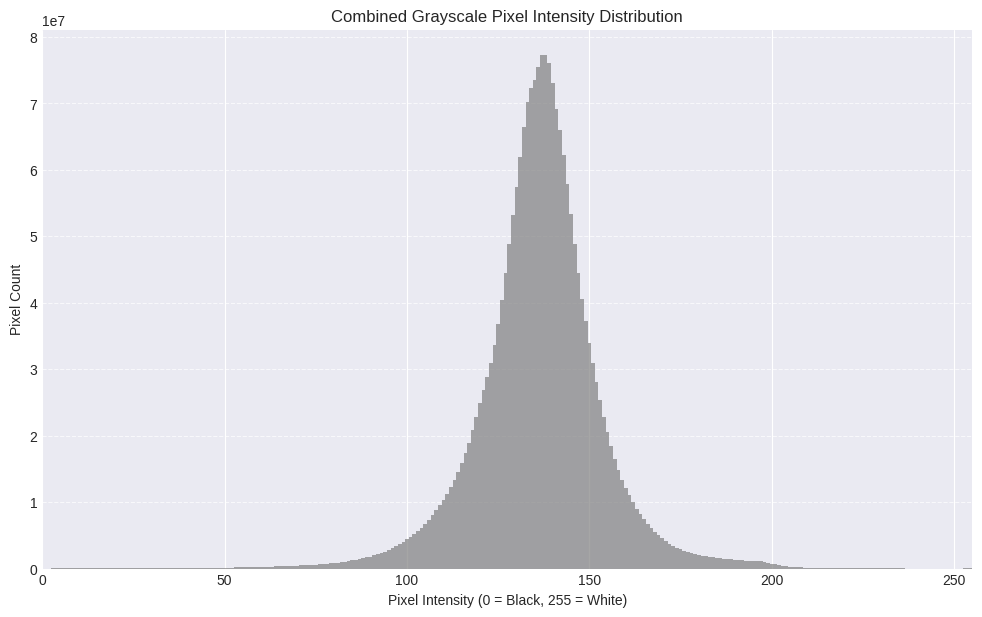

In [48]:
bin_centers = np.arange(256)
plt.figure(figsize=(12,7))
plt.bar(bin_centers, consolidated_histogram, width=1, color='gray', alpha=0.7,
        label='Pixel Counts')
plt.title('Combined Grayscale Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity (0 = Black, 255 = White)')
plt.ylabel('Pixel Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 255)
plt.show()

<p align='center'>
• Bars are relatively evenly distributed or centered around the middle(100-200)<br>
• A more symmetrical shape centered in almost middle of the X-axis indicating balanced brightness<br> i.e good mix of dark, midtone, bright pixels.<br>
• Bars are concentrated in a moderate range on the X-axis (e.g., mostly between 60 and 210), <br>indicating moderate contrast.<br>
• The histogram is a tall, moderately narrow cluster, often somewhere in the middle, with very few or no bars at the extreme ends.<br>
• This moderate range still indicates that the images could benefit from <b>contrast enhancement</b> <br>to push pixel values closer to the true black and white extremes.<br>
</p>

### Pixel Intensity Distribution (Grayscale) Per Class

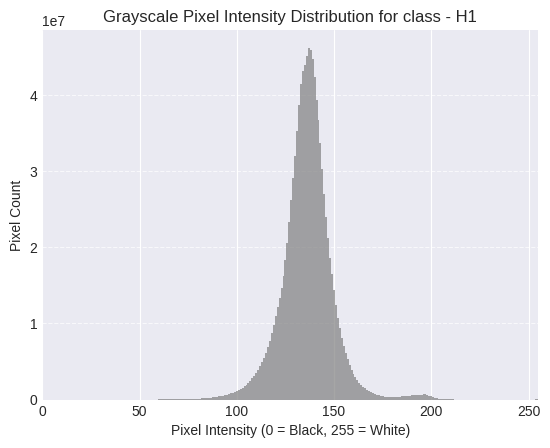

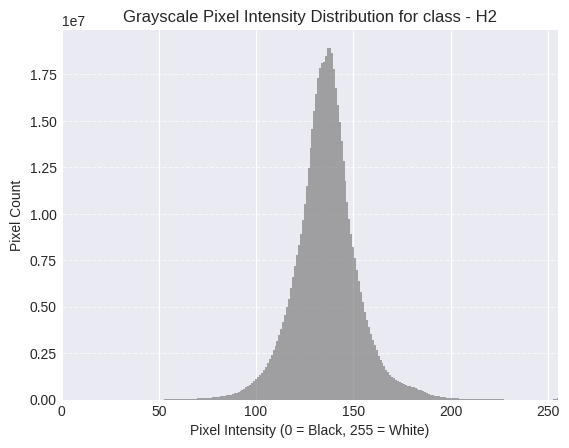

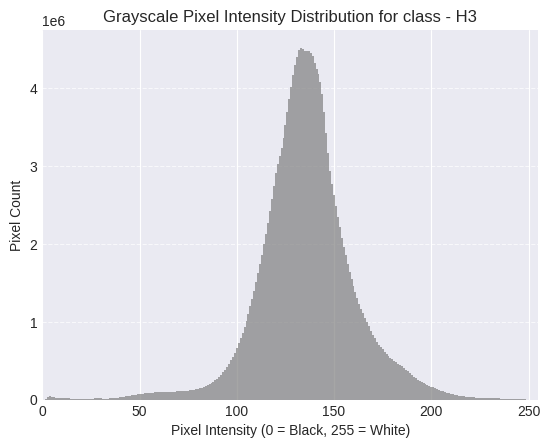

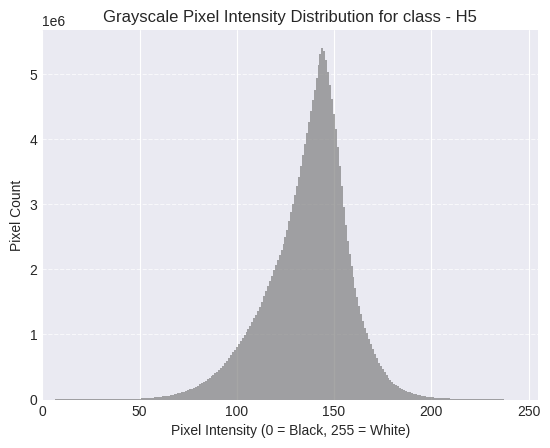

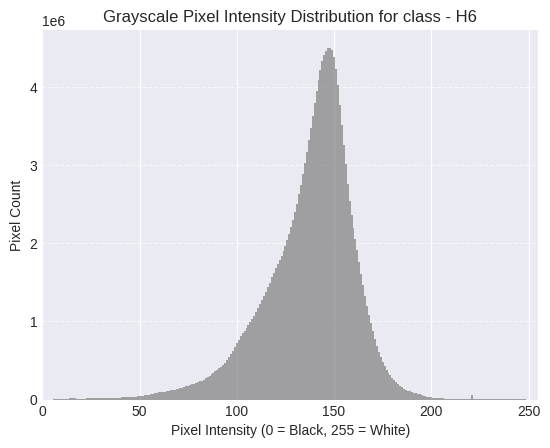

In [49]:

for key, nparray in class_wise_histogram.items():
  plt.bar(bin_centers, nparray, width=1, color='gray', alpha=0.7,
        label='Pixel Counts')
  plt.title(f'Grayscale Pixel Intensity Distribution for class - {key}')
  plt.xlabel('Pixel Intensity (0 = Black, 255 = White)')
  plt.ylabel('Pixel Count')
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.xlim(0, 255)
  plt.show()



<p align='center'>
<b>It appears the images related to class H5 and H6 are on brighter side (better pixel intensity) compared to Images of classes H1, H2, H3.</b>
</p>